# Problem

We solve a reaction diffusion advection problem involving three species
with a given velocity field. The stream function $\psi$ for the velocity field is
hereby the solution to the Laplace-equation:

\begin{align*}
  - \Delta \psi &= 0.8\pi 2 \sin(2\pi x) \sin(2\pi y) \quad \mbox{ in } \Omega = [0,1]^2,\\
   \psi &= 0 \quad \mbox{ on } \partial \Omega.
\end{align*}

With that the velocity field is given by
\begin{equation}
 w = (-\partial_y \psi, \partial_x \psi )
\end{equation}

The three species $u = (u_0, u_1, u_2 )$ satisfy the PDE:
\begin{align*}
\int_{\Omega} &\frac{u^{n+1}-u^n}{\Delta t} v
     + K(\nabla u^{n+1}) \nabla u^{n+1} \cdot \nabla v \; dx
     = \int_{\Omega} f(x,t^n+\Delta t) v\; dx
   + \int_{\partial \Omega} g(x,t^n+\Delta t)\cdot n \; v\; ds~.
\end{align*}

where $S$ describes some source or sink and the reaction term is given by
\begin{equation}
R(u) = K (- u_0u_1, -u_0u_1, 2 u_0u_1 - 10 u_2)^T
\end{equation}
where $K$ is a reaction coefficient.


Computed solution at time 0.5000000000000002 iterations:  5 #elem:  10000
Computed solution at time 1.0000000000000007 iterations:  4 #elem:  10000
Computed solution at time 1.500000000000001 iterations:  3 #elem:  10000
Computed solution at time 2.0000000000000013 iterations:  3 #elem:  10000
Computed solution at time 2.5099999999999905 iterations:  4 #elem:  10000
Computed solution at time 3.00999999999998 iterations:  4 #elem:  10000
Computed solution at time 3.509999999999969 iterations:  4 #elem:  10000
Computed solution at time 4.009999999999959 iterations:  3 #elem:  10000
Computed solution at time 4.509999999999948 iterations:  3 #elem:  10000
Computed solution at time 5.009999999999938 iterations:  3 #elem:  10000


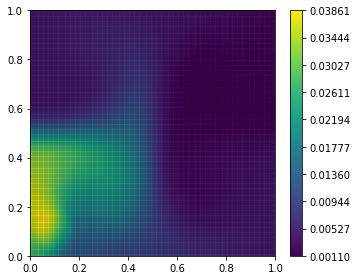

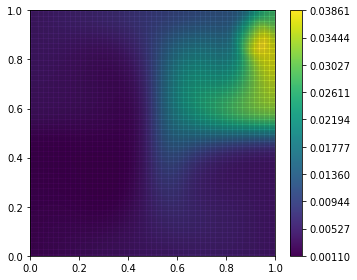

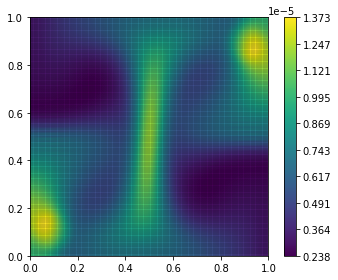

In [1]:
import math
import ufl
from ufl import grad, div, dot, dx, inner, sin, cos, pi
import dune.ufl
import dune.grid
import dune.fem

endTime  = 5
saveInterval = 0.5

gridView = dune.grid.structuredGrid([0,0],[1,1],[100,100])

# Define stream-function and transport field w
# analytic:
# Psi     = 0.1*sin(2*pi*x[0])*sin(2*pi*x[1])
# discrete:
velocitySpace = dune.fem.space.lagrange(gridView, order=1)
Psi  = velocitySpace.interpolate(0,name="stream_function")
u    = ufl.TrialFunction(velocitySpace)
phi  = ufl.TestFunction(velocitySpace)
x    = ufl.SpatialCoordinate(velocitySpace)
form = ( inner(grad(u),grad(phi)) -
         0.1*2*(2*pi)**2*sin(2*pi*x[0])*sin(2*pi*x[1]) * phi ) * dx
dbc  = dune.ufl.DirichletBC(velocitySpace,0)
velocityScheme = dune.fem.scheme.galerkin([form == 0, dbc], solver="cg")
velocityScheme.solve(target=Psi)
w       = ufl.as_vector([-Psi.dx(1),Psi.dx(0)])

space = dune.fem.space.lagrange(gridView, order=1, dimRange=3)
u     = ufl.TrialFunction(space)
phi   = ufl.TestFunction(space)
x     = ufl.SpatialCoordinate(space)

# reaction, diffusion and other coefficients
K   = dune.ufl.Constant(10.0, "reactionRate")
eps = dune.ufl.Constant(0.01, "diffusionRate")
dt  = dune.ufl.Constant(0.01, "dt")
Q   = dune.ufl.Constant(0.1, "sourceStrength")

# define storage for discrete solutions
uh     = space.interpolate([0,0,0], name="uh")
uh_old = uh.copy()

# define source terms
P1 = ufl.as_vector([0.1,0.1])
P2 = ufl.as_vector([0.9,0.9])
RF = 0.075
f1 = ufl.conditional(dot(x-P1,x-P1) < RF**2, Q, 0)
f2 = ufl.conditional(dot(x-P2,x-P2) < RF**2, Q, 0)
f  = ufl.as_vector([f1,f2,0])

# reaction rates
r   = K*ufl.as_vector([u[0]*u[1], u[0]*u[1], -2*u[0]*u[1] + 10*u[2]])

xForm = (dot(grad(u)*w + r - f, phi) + eps * inner(grad(u), grad(phi))) * dx
form  = dot(u - uh_old, phi) * dx + dt * xForm

scheme = dune.fem.scheme.galerkin(form == 0, solver="gmres")

nextSaveTime = saveInterval
vtk = gridView.sequencedVTK("reactionsystem", pointdata=[uh], pointvector={"velocity":w})
vtk()

# set time step size
scheme.model.dt = 0.01

scheme.model.reactionRate  = 10.
scheme.model.diffusionRate = 0.01
scheme.model.sourceStrength = 0.1

t = 0
while t < endTime:
    uh_old.assign(uh)
    info = scheme.solve(target=uh)
    t += dt.value
    if t >= nextSaveTime or t >= endTime:
        print("Computed solution at time",t,\
              "iterations: ", info["linear_iterations"], "#elem: ", gridView.size(0) )
        vtk()
        nextSaveTime += saveInterval

uh[0].plot()
uh[1].plot()
uh[2].plot()